# [5SSD0] Probabilistic Programming - Assignment 1

Year: 2023-2024

In this assignment, we will go through the Bayesian model design cycle:

 <img src="figures/modelling-procedure.png" alt="" width="600"> 

You will build a simple model, fit it to data and evaluate its performance on future data. Its performance is not great and you are challenged to improve it.

In [ ]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()

In [1]:
using CSV
using DataFrames
using LinearAlgebra
using ProgressMeter
using RxInfer
using Plots
default(label="",
        grid=false, 
        linewidth=3, 
        markersize=4,
        guidefontsize=12, 
        margins=15Plots.pt)

  Activating project at `~/syndr/Wouter/Onderwijs/Vakken/tueindhoven/5SSD0 - Bayesian Machine Learning & Information Processing/2023-2024 Q2/Assignments/5SSD0-ProbabilisticProgramming/source`


## Problem: Forecasting Air Quality

Many Europeans suspect that the air quality in their city is declining. A [recent study](https://doi.org/10.1016/j.snb.2007.09.060) measured the air quality of a major city in North Italy using an electronic nose. The measurements were made in the middle of the city and reflect urban activity. We will inspect the specific chemical concentrations found and build a model to accurately predict CO for future time points.

![https://www.theguardian.com/environment/2020/apr/07/air-pollution-linked-to-far-higher-covid-19-death-rates-study-finds](figures/air-milan-wide.png)

Photograph taken by Claudio Furlan/LaPresse/Zuma Press/Rex/Shutterstock ([link](https://www.theguardian.com/environment/2020/apr/07/air-pollution-linked-to-far-higher-covid-19-death-rates-study-finds))

### Data

The data can be found here: https://archive.ics.uci.edu/ml/datasets/Air+Quality. I've done some pre-processing and selected the most important features. In this assignment we will infer parameters in a model of the data and predict air quality in the future. For that purpose, the data has been split into past and future.

In [2]:
past_data = DataFrame(CSV.File("data/airquality_past.csv"))

Row,time,CO
,DateTime,Float64
1,2004-03-10T18:00:00,1360.0
2,2004-03-10T19:00:00,1292.0
3,2004-03-10T20:00:00,1402.0
4,2004-03-10T21:00:00,1376.0
5,2004-03-10T22:00:00,1272.0
6,2004-03-10T23:00:00,1197.0
7,2004-03-11T00:00:00,1185.0
8,2004-03-11T01:00:00,1136.0
9,2004-03-11T02:00:00,1094.0


Let's visualize the carbon monoxide measurements over time.

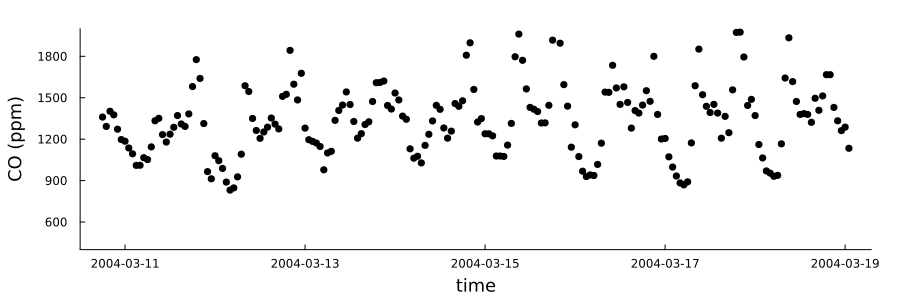

In [3]:
scatter(past_data[:,1], 
        past_data[:,2], 
        size=(900,300), 
        color="black", 
        xlabel="time", 
        ylabel="CO (ppm)",
        ylims=[400,2000])

## 1. Model specification & parameter estimation

We suspect that there is a temporal dependence in this dataset. In other words, the data changes relatively slowly over time and neighbouring data points end up being highly correlated. To exploit this correlation, we will build an _auto-regressive model_ of the form:

$$ y_k = \theta y_{k-1} + \epsilon_k \, , $$

where the noise $\epsilon_k$ is drawn from a zero-mean Gaussian with precision parameter $\tau$: 

$$ \epsilon_k \sim \mathcal{N}(0, \tau^{-1}) \, .$$

For now, we will use $\tau = 1.0$.

Tasks:
- [1pt] Specify the above equation as a probabilistic model in RxInfer, and infer a posterior distribution for $\theta$. Plot the inferred distribution over the interval $[0.9,\ 1.0]$.

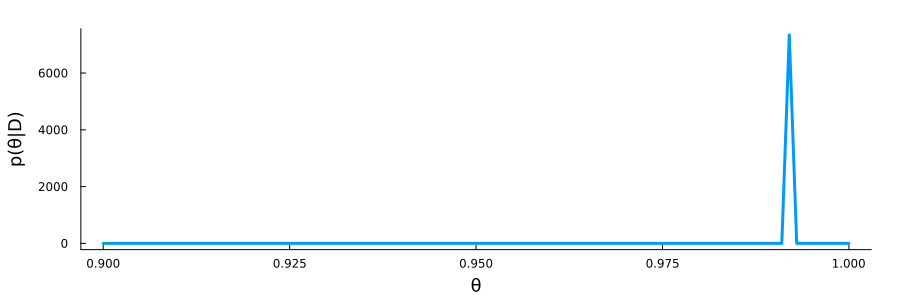

In [4]:
### BEGIN SOLUTION

# Likelihood precision
τ = 1.0

# Number of data points
T = size(past_data,1);

# Prepare data
y_k    = [past_data[i,2] for i in 2:T]
y_prev = [past_data[i,2] for i in 1:(T-1)];

# Specify parameters of prior distributions
prior_params = Dict(:θ => (1.0, 100.0))

@model function auto_regression1(prior_params; num_samples=1)
    
    x = datavar(Float64,num_samples)
    y = datavar(Float64,num_samples)
    
    # Prior coefficients
    θ ~ Normal(mean = prior_params[:θ][1], variance = prior_params[:θ][2])

    # Likelihood
    for i = 1:num_samples
        y[i] ~ Normal(mean = θ*x[i], precision = τ)
    end
    return y, x, θ
end

results = inference(
    model         = auto_regression1(prior_params, num_samples=T-1),
    data          = (x = y_prev, y = y_k,),
    free_energy   = true,
)

# Plot posterior
plot(0.9:1e-3:1.0, x -> pdf(results.posteriors[:θ], x), xlabel="θ", ylabel="p(θ|D)", size=(900,300))

### END SOLUTION

## 2. Predictions & model evaluation

We want to evaluate the parameters inferred under the model. For now, we will do this by visually inspecting the 1-step ahead predictions on our data set. Later, we will use free energy as a metric. 

The posterior predictive distribution for the next time step is:

$$ p(y_{k+1} \mid \bar{y}_k, \mathcal{D}) = \int p(y_{k+1} \mid \theta, \bar{y}_k) p(\theta \mid \mathcal{D}) \, \mathrm{d}\theta \, , $$

where $\mathcal{D}$ refers to the past data (used to infer the posterior distribution) and $\bar{y}$ refers to the previous $M$ data points (i.e. $\bar{y}_k = [y_{k-1} \dots y_{k-M}]$). To make 1-step ahead predictions, you will have to loop over the data (i.e., `for k in 1:T`), plug in the current data point and compute the parameters of the posterior predictive distribution for the next data point. You may start from $k=2$, using $y_1$ as initial "previous observation". 

Tasks:
- [1pt] Derive the parameters of the posterior predictive and compute the 1-step ahead predictions on the data set. Plot the first 10 predictions (_mean and 1 standard deviation_) along with the data $y_{2:11}$.

---

Note that if you failed to infer a posterior distribution in the previous question, you can still answer this question using a standard normal, $p(\theta) = \mathcal{N}(0,1)$.

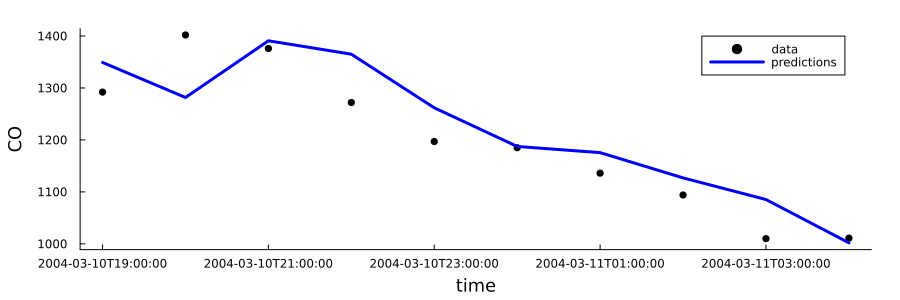

In [5]:
### BEGIN SOLUTION

# Preallocate predictions
sim_mean = zeros(T)
sim_stds = zeros(T)

# Initialize recursive previous
y_prev = past_data[1,2]

# Extract parameters of posterior
mθ, vθ = mean_var(results.posteriors[:θ])

for t = 2:T
    
    # Compute parameters of posterior
    sim_mean[t] = mθ*y_prev
    sim_stds[t] = sqrt(y_prev*vθ*y_prev + τ)
    
    # Update data
    y_prev = past_data[t,2]
    
end

scatter(past_data[2:11,1], past_data[2:11,2], color="black", label="data", xlabel="time", ylabel="CO")
plot!(past_data[2:11,1], sim_mean[2:11], ribbon=sim_stds[2:11], color="blue", size=(900,300), label="predictions")

### END SOLUTION

## 3. Model critiqueing & improvement

From the results of the previous question, you may conclude that our initial model isn't great: it only considers extremely short-term changes, which are highly affected by noise. If we want the model to consider changes over longer periods of time, then we need to increase the order of the auto-regressive model. That corresponds to:

$$ y_k = \sum_{m=1}^{M} \theta_m y_{k-m} + \epsilon_k \, ,$$

where $M$ refers to model order.

Tasks:
- [1pt] Specify a higher-order AR model with an order parameter $M$, and with an appropriate prior on the AR coefficients. Visualize the 1-step ahead predictions (_mean and variance_) on the data.

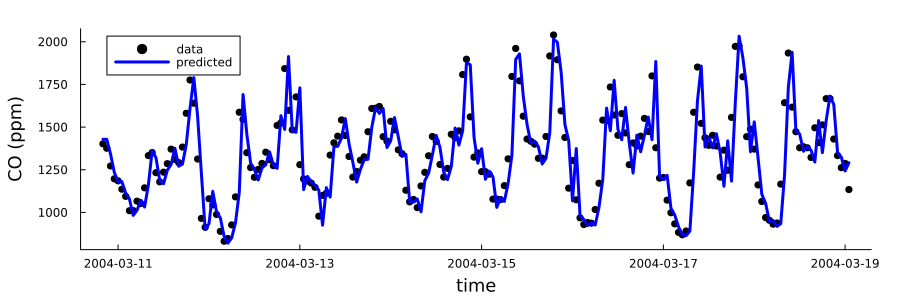

In [6]:
### BEGIN SOLUTION

# Model order
M = 3;

# Number of data points
T = size(past_data,1);

# Prepare data
y_k    = [past_data[i,2] for i in (M+1):T]
y_prev = [past_data[i-1:-1:i-M,2] for i in (M+1):T]

# Specify parameters of prior distributions 
prior_params = Dict(:θ => (exp.(-(1:M)), diagm(ones(M))))

@model function auto_regression2(prior_params; τ=1.0, model_order=2, num_samples=1)
    
    x = datavar(Vector{Float64}, num_samples)
    y = datavar(Float64, num_samples)
    
    # Prior coefficients
    θ ~ MvNormal(mean = prior_params[:θ][1], covariance = prior_params[:θ][2])

    # Likelihood
    for i = 1:num_samples
        y[i] ~ Normal(mean = dot(θ,x[i]), precision = τ)
    end
    return y, x, θ
end

results = inference(
    model         = auto_regression2(prior_params, model_order=M, num_samples=T-M),
    data          = (x = y_prev, y = y_k,),
)

# Preallocate predictions
sim_mean = zeros(T)
sim_stds = zeros(T)

# Initialize recursive previous
y_prev = past_data[M:-1:1,2]

# Extract parameters of posterior
mθ, Sθ = mean_cov(results.posteriors[:θ])

for t = M:T
    
    # Compute parameters of posterior
    sim_mean[t] = mθ'*y_prev
    sim_stds[t] = sqrt(y_prev'*Sθ*y_prev + inv(τ))
    
    # Update recursion
    y_prev = past_data[t:-1:t-M+1,2]
    
end

scatter(past_data[M:T,1], past_data[M:T,2], color="black", label="data", xlabel="time", ylabel="CO (ppm)")
plot!(past_data[M:T,1], sim_mean[M:T], ribbon=sim_stds[M:T], color="blue", size=(900,300), label="predicted")

### END SOLUTION

## 4. Model selection & deployment

Every value of $M$ produces a different model. But which is the best? 

For now, we will evaluate models using a non-Bayesian criterion. The mean-squared error between the MAP solution and future data can be calculated with:

$$ \text{MSE} = \frac{1}{T} \sum_{k=1}^{T} \big(\sum_{m=1}^{M} \hat{\theta}^{\text{MAP}}_m y_{k-m} - y_{k} \big)^2 $$

Tasks:
- [1pt] Compute the mean squared errors for a range of values of $M$ (AR model order) and report the best performing one.
- [1pt] Deploy the best model on the future data (1-step ahead predictions) and visualize the predictions (_mean and 1 standard deviation_).

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


MSE indicates M = 32 is optimal.


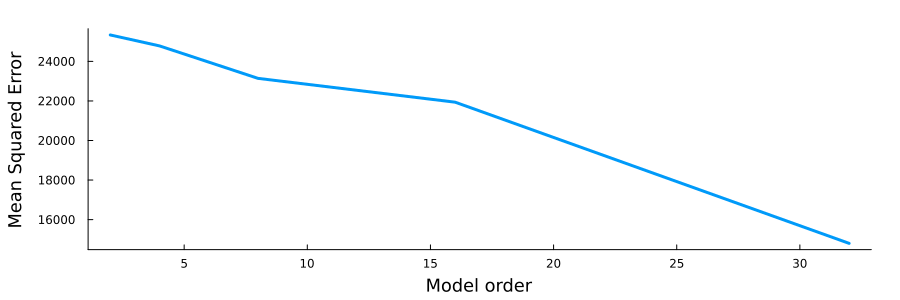

In [7]:
### BEGIN SOLUTION

# Model order range
model_orders = [2,4,8,16,32];

# Preallocate errors
MSE = zeros(length(model_orders))

# Preallocate list of posteriors
posts = Vector(undef, length(model_orders))

results = []

# Loop over model orders
@showprogress for (j,m) in enumerate(model_orders)
    
    # Prepare data
    y_k    = [past_data[i,2] for i in (m+1):T]
    y_prev = [past_data[i-1:-1:i-m,2] for i = (m+1):T]

    # Specify parameters of prior distributions 
    prior_params = Dict(:θ => (exp.(-(1:m)), diagm(ones(m))))

    results = inference(
        model         = auto_regression2(prior_params, model_order=m, num_samples=T-m),
        data          = (x = y_prev, y = y_k,),
    )
    
    # Store final FE
    θ_MAP = mode(results.posteriors[:θ])
    preds = [dot(θ_MAP, y_) for y_ in y_prev]
    MSE[j] = mean( (preds .- y_k).^2 )
    
    # Save posteriors
    posts[j] = results.posteriors
end

# Extract best model and report
M_best = model_orders[argmin(MSE)]
println("MSE indicates M = "*string(M_best)*" is optimal.")

# Visualize free energies
plot(model_orders, MSE, 
    xlabel="Model order", 
    ylabel="Mean Squared Error", 
    size=(900,300))

### END SOLUTION

In [8]:
# Load test data
future_data = DataFrame(CSV.File("data/airquality_future.csv"))

Row,time,CO
,DateTime,Float64
1,2004-03-19T02:00:00,999.0
2,2004-03-19T03:00:00,961.0
3,2004-03-19T04:00:00,934.0
4,2004-03-19T05:00:00,913.0
5,2004-03-19T06:00:00,969.0
6,2004-03-19T07:00:00,1182.0
7,2004-03-19T08:00:00,1740.0
8,2004-03-19T09:00:00,1819.0
9,2004-03-19T10:00:00,1427.0


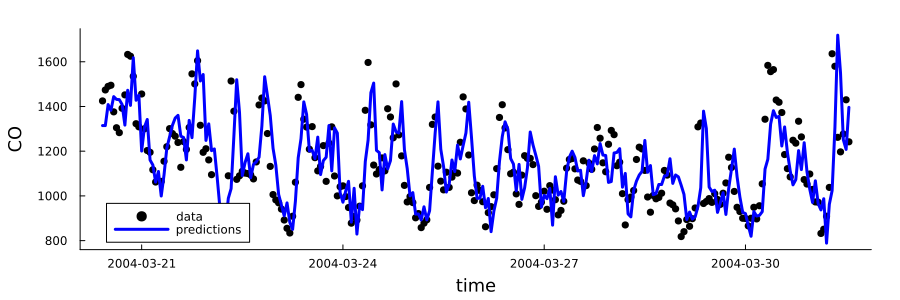

In [9]:
### BEGIN SOLUTION

# Select posterior
best_post = posts[argmin(MSE)]

# Extract parameters of selected posterior
mθ, Sθ = mean_cov(best_post[:θ])

T = size(future_data,1)

# Preallocate predictions
sim_mean = zeros(T)
sim_stds = zeros(T)

# Initialize recursive previous
y_prev = future_data[M_best:-1:1,2]

for t = (M_best+1):T
    
    # Compute parameters of posterior
    sim_mean[t] = mθ'*y_prev
    sim_stds[t] = sqrt(y_prev'*Sθ*y_prev + inv(τ))
    
    # Update data
    y_prev = future_data[t-1:-1:t-M_best,2]
    
end

ix = (M_best+1):300
scatter(future_data[ix,1], future_data[ix,2], color="black", label="data", xlabel="time", ylabel="CO")
plot!(future_data[ix,1], sim_mean[ix], ribbon=sim_stds[ix], color="blue", size=(900,300), label="predictions")

### END SOLUTION